# Inference

In [1]:
!python3 -m pip install pillow smart_open[s3] numpy opencv-python-headless scikit-learn scikit-image matplotlib boto3 gdown
!python3 -m pip install ISR==2.2.0
!python3 -m pip install six --force-reinstall
!python3 -m pip install h5py==2.10.0 --force-reinstall
# !python3 -m pip uninstall tensorflow ISR -y
# !python3 -m pip install tensorflow==2.0.0
# !python3 -m pip install ISR==2.2.0 --no-deps


     |################################| 22.2 MB 5.5 MB/s            
     |################################| 12.4 MB 20.6 MB/s            
     |################################| 25.9 MB 62.0 MB/s            
     |################################| 306 kB 63.2 MB/s            
     |################################| 1.6 MB 26.9 MB/s            
     |################################| 148 kB 69.7 MB/s            
     |################################| 4.4 MB 59.1 MB/s            
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
     |################################| 86.3 MB 40.4 MB/s            
  Preparing metadata (setup.py) ... done
     |################################| 3.8 MB 27.8 MB/s            
     |################################| 449 kB 59.1 MB/s            
     |################################| 50 kB 8.4 MB/s             
     |############################

In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
from inferencev2 import *
import pathlib
from IPython.display import display, HTML
import pandas as pd

/usr/local/lib/python3.6/dist-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [5]:
# import os
# import pathlib
# import shutil

# def rename_folder(folder, file):
#     new_name = 'compress100'.join(file.split('compress50'))
#     new_name = 'sharpen0'.join(new_name.split('sharpen1'))
#     new_name = 'T0'.join(new_name.split('T0.0'))
#     # shutil.move(folder / file, folder / new_name)
#     print(file, new_name)

# def rename_all(folder):
#     folders_to_rename = []
#     for file in os.listdir(folder):
#         if not file.startswith('.'):
#             if 'compress' in file:
#                 folders_to_rename.append((folder, file))
#             if os.path.isdir(folder / file):
#                 rename_all(folder / file)
    
#     folders_to_rename.sort()
#     for folder, file in folders_to_rename:
#         rename_folder(folder, file)
            
    
# rename_all(pathlib.Path('../volumes/checkpoints/weights'))

# import os
# import pathlib
# import shutil

# def rename_folder(folder, file):
#     new_name = 'compress100'.join(file.split('compress50'))
#     new_name = 'sharpen0'.join(new_name.split('sharpen1'))
#     new_name = 'T0'.join(new_name.split('T0.0'))
#     new_name = f'{new_name}-datadiv2k'
#     shutil.move(folder / file, folder / new_name)
#     print(file, new_name)

# def rename_all(folder):
#     folders_to_rename = []
#     for file in os.listdir(folder):
#         if not file.startswith('.'):
#             if 'data' not in file:
#                 folders_to_rename.append((folder, file))
    
#     folders_to_rename.sort()
#     for folder, file in folders_to_rename:
#         rename_folder(folder, file)
            
    
# rename_all(pathlib.Path('../volumes/checkpoints/weights'))

In [6]:
from tqdm import tqdm

def evaluate_results_against_dataset(dataset, validparams=None, reset_cache=False, show_n=0, show_best_n=0, show_worst_n=0, check_every_model=False): 
    DATASET_PATH = pathlib.Path(dataset)
    dataset = Dataset(DATASET_PATH)
    evaluator = Evaluator(dataset)

    results = evaluate_jobs(evaluator, '../volumes/checkpoints/weights', 
                            reset_cache=reset_cache, 
                            validparams=validparams,
                            show_n=show_n, 
                            show_best_n=show_best_n, 
                            show_worst_n=show_worst_n,
                            check_every_model=check_every_model,
                           )
    data = []
    for trained_job, result, model_name in results:
        metrics = result.get_results()
        split_model_name = model_name.split('-')
        epoch_number = '-'.join(split_model_name[7:]).split('epoch').pop().split('.hdf5')[0]
        params = '-'.join(split_model_name[1:7])
        data.append(('-'.join(model_name.split('-')[11:]), params, epoch_number, split_model_name[0], trained_job.get_vary_compression(), trained_job.get_compression(), trained_job.get_sharpen(), trained_job.get_dataset(), *metrics))
    df = pd.DataFrame(
        data=data,
        columns=['Name', 'Params', 'Epoch', 'Arch', 'Vary Compression', 'Compression', 'Sharpen', 'Dataset', 'Total Time', 'Time per 100 pixels', 'PSNR Mean', 'PSNR Median', 'SSIM Mean', 'SSIM Median']
    )
    df.set_index('Name')
    df = df.sort_values('PSNR Mean', ascending=False)
    # display(df[df.columns[1:]])
    display(df[df.columns[0:]])    
    return df, results, model_name
    
    
def evaluate_models(scale, reset_cache=True):
    # validparams={'C': 4, 'D': 3, 'G': 4, 'G0': 64, 'arch': 'rdn'}
    for validparams in [
        { 'arch': 'rdn', 'C': 1, 'D': 2, 'x': scale, },
        { 'arch': 'rdn', 'C': 1, 'D': 10, 'x': scale, },
        { 'arch': 'rrdn', 'x': scale, },
    ]:

        results = {}
        for dataset in [
            '/notebooks/data/div2k/DIV2K_valid_HR', 
            # '/notebooks/data/ffhq/preprocessed/4x/valid/hr',
            # '/notebooks/data/wikiart/preprocessed/4x/valid/hr', 
        ]:
            # display(HTML(f'<h1>{dataset}</h1>'))
            results[dataset] = evaluate_results_against_dataset(
                dataset, 
                validparams=validparams, 
                reset_cache=reset_cache,
                # show_worst_n=5,
                # show_n=5,
                check_every_model=True,
            )
            for chart, ascending in [
                ('Total Time', True),
                ('PSNR Mean', False),
                # ('PSNR Median', False),
                # ('SSIM Mean', False),
                # ('SSIM Median', False),
            ]:
                df, _results, model_name = results.get(dataset)
                data = df.sort_values(chart, ascending=ascending).reset_index()
                plt.bar("Name", chart, data = data)
                # plt.bar('Name', 'PSNR Mean', data = data, color='r', alpha=0.5, label='Min Power in mW')
                plt.xticks(rotation = 90)
                plt.title(chart)
                plt.ylim(data[chart].min() * 1, data[chart].max() * 1.00)
                plt.show()    

Number of matching training jobs: 1


100%|██████████| 100/100 [00:11<00:00,  8.69it/s]


,Name,Params,Epoch,Arch,Vary Compression,Compression,Sharpen,Dataset,Total Time,Time per 100 pixels,PSNR Mean,PSNR Median,SSIM Mean,SSIM Median
2,vary_cFalse_best-val_loss_epoch494.hdf5,C1-D2-G4-G064-T10-x2,494,rdn,False,100,0,div2k,2090.732,1.613219,29.325640,28.787323,0.866049,0.876479
8,vary_cFalse_epoch491.hdf5,C1-D2-G4-G064-T10-x2,491,rdn,False,100,0,div2k,1918.659,1.480447,29.323028,28.781014,0.866203,0.876178
6,vary_cFalse_best-val_generator_PSNR_Y_epoch483...,C1-D2-G4-G064-T10-x2,483,rdn,False,100,0,div2k,1892.576,1.460321,29.320599,28.778656,0.865826,0.875799
9,vary_cFalse_best-val_generator_loss_epoch499.hdf5,C1-D2-G4-G064-T10-x2,499,rdn,False,100,0,div2k,1811.286,1.397597,29.301069,28.781076,0.865905,0.876178
5,vary_cFalse_best-val_generator_loss_epoch500.hdf5,C1-D2-G4-G064-T10-x2,500,rdn,False,100,0,div2k,1810.137,1.396711,29.300678,28.777077,0.865720,0.875774
0,vary_cFalse_epoch481.hdf5,C1-D2-G4-G064-T10-x2,481,rdn,False,100,0,div2k,1826.030,1.408974,29.291717,28.758538,0.865341,0.874800
1,vary_cFalse_epoch486.hdf5,C1-D2-G4-G064-T10-x2,486,rdn,False,100,0,div2k,1891.606,1.459573,29.288365,28.753025,0.865164,0.874244
4,vary_cFalse_best-val_generator_PSNR_Y_epoch488...,C1-D2-G4-G064-T10-x2,488,rdn,False,100,0,div2k,1858.823,1.434277,29.283632,28.755874,0.865604,0.875210
7,vary_cFalse_epoch497.hdf5,C1-D2-G4-G064-T10-x2,497,rdn,False,100,0,div2k,2010.824,1.551562,29.274151,28.752990,0.865291,0.875164
3,vary_cFalse_epoch478.hdf5,C1-D2-G4-G064-T10-x2,478,rdn,False,100,0,div2k,2208.318,1.703949,29.163146,28.680593,0.864928,0.874393


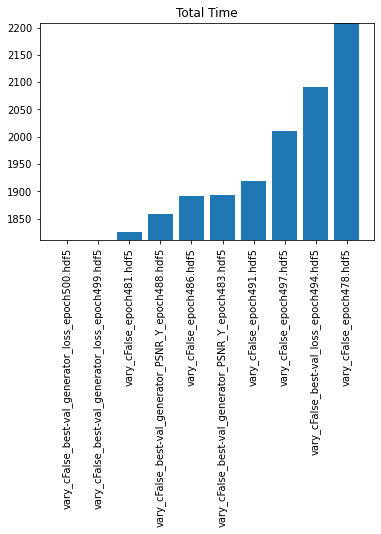

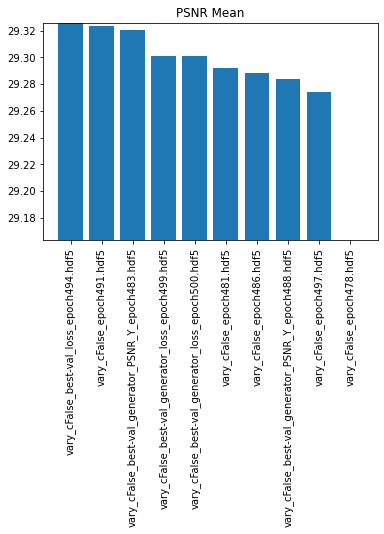

Number of matching training jobs: 1


100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


,Name,Params,Epoch,Arch,Vary Compression,Compression,Sharpen,Dataset,Total Time,Time per 100 pixels,PSNR Mean,PSNR Median,SSIM Mean,SSIM Median
4,vary_cFalse_best-val_generator_PSNR_Y_epoch478...,C1-D10-G64-G064-T10-x2,478,rdn,False,100,0,div2k,4144.221,3.197701,29.752218,28.970088,0.870097,0.882808
6,vary_cFalse_best-val_loss_epoch499.hdf5,C1-D10-G64-G064-T10-x2,499,rdn,False,100,0,div2k,4332.386,3.342890,29.737470,28.964903,0.870265,0.883288
7,vary_cFalse_best-val_generator_loss_epoch500.hdf5,C1-D10-G64-G064-T10-x2,500,rdn,False,100,0,div2k,4117.778,3.177298,29.713869,28.920185,0.868966,0.880457
9,vary_cFalse_epoch485.hdf5,C1-D10-G64-G064-T10-x2,485,rdn,False,100,0,div2k,4464.433,3.444779,29.705268,28.935213,0.869356,0.881591
5,vary_cFalse_epoch496.hdf5,C1-D10-G64-G064-T10-x2,496,rdn,False,100,0,div2k,4130.513,3.187124,29.701692,28.945525,0.869746,0.882024
3,vary_cFalse_best-val_loss_epoch493.hdf5,C1-D10-G64-G064-T10-x2,493,rdn,False,100,0,div2k,4060.346,3.132983,29.698890,28.932331,0.869581,0.881754
0,vary_cFalse_best-val_generator_loss_epoch479.hdf5,C1-D10-G64-G064-T10-x2,479,rdn,False,100,0,div2k,4150.991,3.202925,29.682692,28.912557,0.868914,0.881222
2,vary_cFalse_epoch488.hdf5,C1-D10-G64-G064-T10-x2,488,rdn,False,100,0,div2k,3916.127,3.021703,29.678817,28.908314,0.869079,0.881660
8,vary_cFalse_epoch482.hdf5,C1-D10-G64-G064-T10-x2,482,rdn,False,100,0,div2k,4181.269,3.226288,29.667304,28.923330,0.868758,0.880420
1,vary_cFalse_epoch491.hdf5,C1-D10-G64-G064-T10-x2,491,rdn,False,100,0,div2k,4049.879,3.124907,29.664535,28.924829,0.869411,0.881685


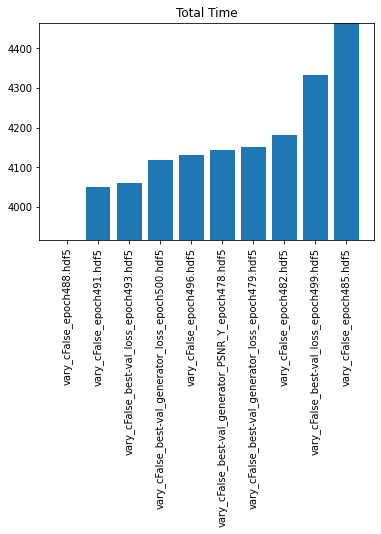

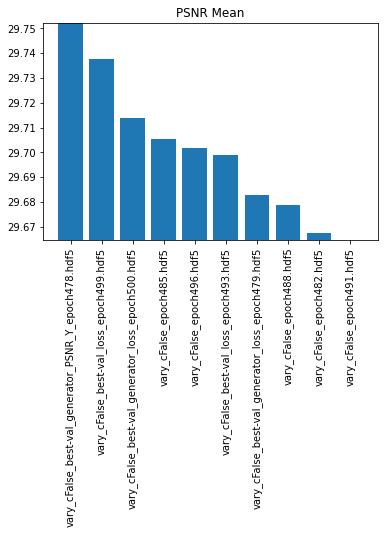

Number of matching training jobs: 1


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


,Name,Params,Epoch,Arch,Vary Compression,Compression,Sharpen,Dataset,Total Time,Time per 100 pixels,PSNR Mean,PSNR Median,SSIM Mean,SSIM Median
19,vary_cFalse_best-val_loss_epoch500.hdf5,C4-D3-G32-G064-T10-x2,500,rrdn,False,100,0,div2k,36244.541,27.966467,30.284181,29.374802,0.879568,0.892516
4,vary_cFalse_best-val_loss_epoch476.hdf5,C4-D3-G32-G064-T10-x2,476,rrdn,False,100,0,div2k,35752.605,27.586887,30.280473,29.363479,0.879683,0.893221
10,vary_cFalse_best-val_generator_PSNR_Y_epoch475...,C4-D3-G32-G064-T10-x2,475,rrdn,False,100,0,div2k,36485.682,28.152532,30.277977,29.371458,0.879679,0.892191
9,vary_cFalse_best-val_generator_PSNR_Y_epoch485...,C4-D3-G32-G064-T10-x2,485,rrdn,False,100,0,div2k,36817.722,28.408736,30.262456,29.405673,0.879645,0.892744
3,vary_cFalse_best-val_loss_epoch488.hdf5,C4-D3-G32-G064-T10-x2,488,rrdn,False,100,0,div2k,36545.222,28.198474,30.258514,29.394444,0.879741,0.893029
16,vary_cFalse_epoch490.hdf5,C4-D3-G32-G064-T10-x2,490,rrdn,False,100,0,div2k,35816.497,27.636186,30.251558,29.353016,0.879296,0.892274
5,vary_cFalse_best-val_generator_PSNR_Y_epoch483...,C4-D3-G32-G064-T10-x2,483,rrdn,False,100,0,div2k,36582.154,28.226971,30.251026,29.397485,0.879337,0.892580
7,vary_cFalse_epoch482.hdf5,C4-D3-G32-G064-T10-x2,482,rrdn,False,100,0,div2k,35200.781,27.161096,30.247297,29.356598,0.878942,0.892066
12,vary_cFalse_best-val_loss_epoch484.hdf5,C4-D3-G32-G064-T10-x2,484,rrdn,False,100,0,div2k,36607.305,28.246377,30.246660,29.367281,0.879323,0.892007
0,vary_cFalse_best-val_generator_PSNR_Y_epoch453...,C4-D3-G32-G064-T10-x2,453,rrdn,False,100,0,div2k,36623.823,28.259123,30.245871,29.333595,0.879483,0.892507


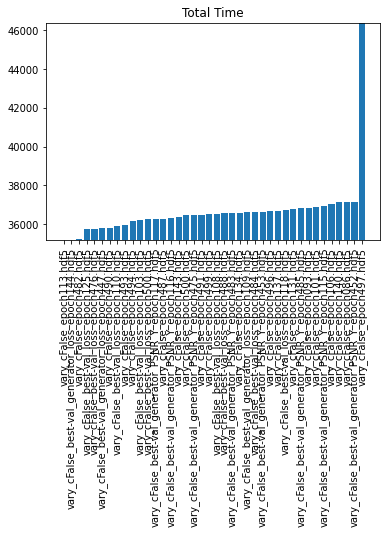

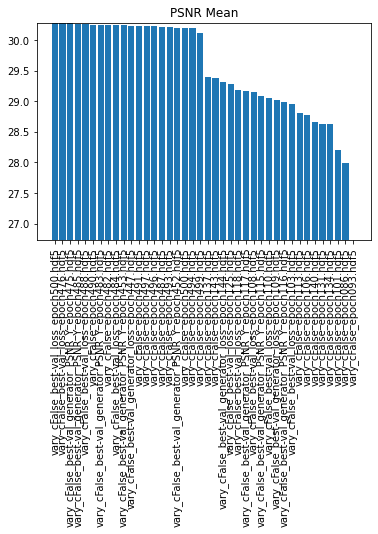

In [63]:
evaluate_models(2)

/usr/local/lib/python3.6/dist-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Number of matching training jobs: 1


100%|██████████| 15/15 [02:57<00:00, 13.36s/it]

100%|██████████| 15/15 [02:57<00:00, 11.83s/it]


,Name,Params,Epoch,Arch,Vary Compression,Compression,Sharpen,Dataset,Total Time,Time per 100 pixels,PSNR Mean,PSNR Median,SSIM Mean,SSIM Median
5,vary_cFalse_best-val_generator_loss_epoch490.hdf5,C1-D2-G4-G064-T10-x3,490,rdn,False,100,0,div2k,1447.612,2.513215,27.080996,26.417641,0.773629,0.790567
1,vary_cFalse_best-val_generator_PSNR_Y_epoch499...,C1-D2-G4-G064-T10-x3,499,rdn,False,100,0,div2k,1449.876,2.517146,27.078552,26.438008,0.773145,0.788965
6,vary_cFalse_epoch488.hdf5,C1-D2-G4-G064-T10-x3,488,rdn,False,100,0,div2k,1418.308,2.462340,27.066972,26.415239,0.773172,0.789835
3,vary_cFalse_epoch497.hdf5,C1-D2-G4-G064-T10-x3,497,rdn,False,100,0,div2k,1417.342,2.460663,27.065029,26.412767,0.772928,0.789519
7,vary_cFalse_epoch482.hdf5,C1-D2-G4-G064-T10-x3,482,rdn,False,100,0,div2k,1485.105,2.578307,27.063830,26.398649,0.773216,0.789561
9,vary_cFalse_best-val_generator_loss_epoch485.hdf5,C1-D2-G4-G064-T10-x3,485,rdn,False,100,0,div2k,1462.179,2.538505,27.063074,26.393080,0.772416,0.789065
4,vary_cFalse_best-val_generator_PSNR_Y_epoch491...,C1-D2-G4-G064-T10-x3,491,rdn,False,100,0,div2k,1451.789,2.520467,27.055227,26.403715,0.772854,0.789582
8,vary_cFalse_best-val_generator_loss_epoch489.hdf5,C1-D2-G4-G064-T10-x3,489,rdn,False,100,0,div2k,1421.234,2.467420,27.054744,26.397030,0.772512,0.789124
2,vary_cFalse_epoch494.hdf5,C1-D2-G4-G064-T10-x3,494,rdn,False,100,0,div2k,1511.642,2.624378,27.039665,26.397702,0.772690,0.789339
0,vary_cFalse_epoch477.hdf5,C1-D2-G4-G064-T10-x3,477,rdn,False,100,0,div2k,1412.105,2.451571,27.026233,26.369857,0.772507,0.788877


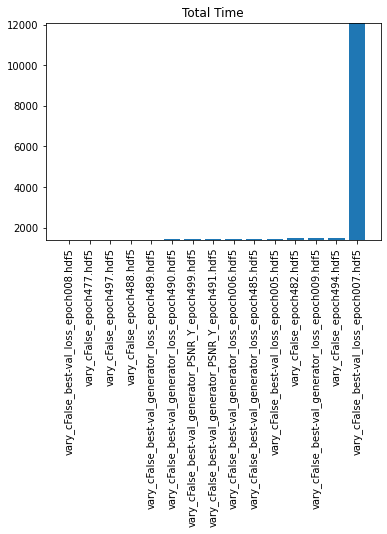

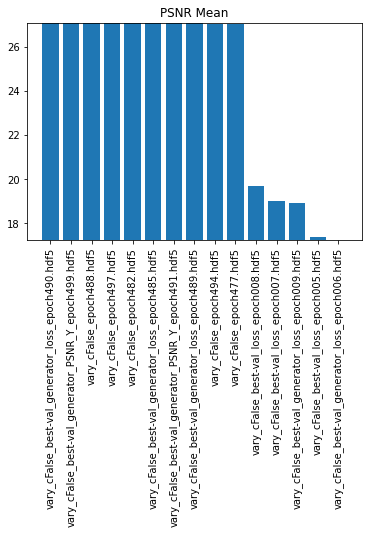

Number of matching training jobs: 1


100%|██████████| 10/10 [02:05<00:00, 12.51s/it]

100%|██████████| 10/10 [02:05<00:00, 12.51s/it]


,Name,Params,Epoch,Arch,Vary Compression,Compression,Sharpen,Dataset,Total Time,Time per 100 pixels,PSNR Mean,PSNR Median,SSIM Mean,SSIM Median
4,vary_cFalse_best-val_generator_PSNR_Y_epoch492...,C1-D10-G64-G064-T10-x3,492,rdn,False,100,0,div2k,2872.859,4.987602,27.363368,26.671300,0.780936,0.799224
3,vary_cFalse_epoch495.hdf5,C1-D10-G64-G064-T10-x3,495,rdn,False,100,0,div2k,2743.636,4.763257,27.357314,26.626610,0.780420,0.798936
1,vary_cFalse_best-val_generator_PSNR_Y_epoch480...,C1-D10-G64-G064-T10-x3,480,rdn,False,100,0,div2k,2738.484,4.754313,27.340462,26.625182,0.779962,0.798274
5,vary_cFalse_best-val_loss_epoch488.hdf5,C1-D10-G64-G064-T10-x3,488,rdn,False,100,0,div2k,2686.586,4.664212,27.338818,26.603856,0.779497,0.797954
0,vary_cFalse_epoch483.hdf5,C1-D10-G64-G064-T10-x3,483,rdn,False,100,0,div2k,2846.292,4.941479,27.334223,26.601686,0.778996,0.797427
2,vary_cFalse_best-val_generator_loss_epoch500.hdf5,C1-D10-G64-G064-T10-x3,500,rdn,False,100,0,div2k,2754.452,4.782035,27.327970,26.619675,0.779640,0.797708
8,vary_cFalse_epoch498.hdf5,C1-D10-G64-G064-T10-x3,498,rdn,False,100,0,div2k,2672.551,4.639845,27.326973,26.635632,0.780304,0.798494
9,vary_cFalse_best-val_generator_loss_epoch490.hdf5,C1-D10-G64-G064-T10-x3,490,rdn,False,100,0,div2k,2821.722,4.898823,27.319076,26.620066,0.778920,0.796671
7,vary_cFalse_epoch478.hdf5,C1-D10-G64-G064-T10-x3,478,rdn,False,100,0,div2k,2789.134,4.842247,27.311680,26.601008,0.778755,0.797174
6,vary_cFalse_epoch486.hdf5,C1-D10-G64-G064-T10-x3,486,rdn,False,100,0,div2k,2763.166,4.797163,27.299289,26.618058,0.779039,0.796949


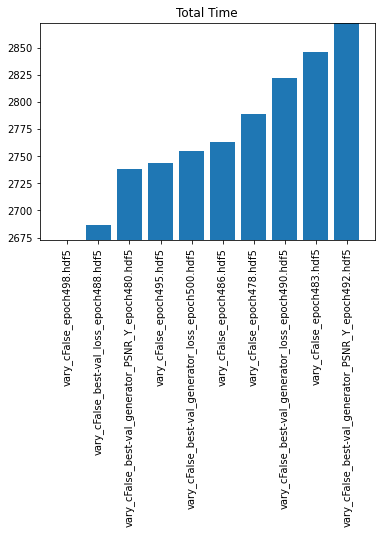

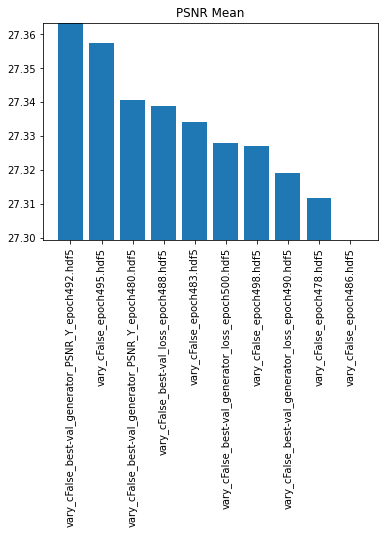

Number of matching training jobs: 1


100%|██████████| 10/10 [04:58<00:00, 29.82s/it]

100%|██████████| 10/10 [04:58<00:00, 29.85s/it]


,Name,Params,Epoch,Arch,Vary Compression,Compression,Sharpen,Dataset,Total Time,Time per 100 pixels,PSNR Mean,PSNR Median,SSIM Mean,SSIM Median
2,vary_cFalse_best-val_loss_epoch483.hdf5,C4-D3-G32-G064-T10-x3,483,rrdn,False,100,0,div2k,20472.487,35.542512,27.913257,27.186710,0.800038,0.815467
9,vary_cFalse_epoch486.hdf5,C4-D3-G32-G064-T10-x3,486,rrdn,False,100,0,div2k,19773.218,34.328503,27.907323,27.198451,0.799936,0.814677
8,vary_cFalse_epoch492.hdf5,C4-D3-G32-G064-T10-x3,492,rrdn,False,100,0,div2k,20205.368,35.078764,27.906866,27.191035,0.799477,0.815180
3,vary_cFalse_epoch498.hdf5,C4-D3-G32-G064-T10-x3,498,rrdn,False,100,0,div2k,20128.386,34.945115,27.900052,27.137741,0.799381,0.814851
1,vary_cFalse_best-val_generator_loss_epoch487.hdf5,C4-D3-G32-G064-T10-x3,487,rrdn,False,100,0,div2k,19780.167,34.340568,27.894759,27.177344,0.799701,0.814800
7,vary_cFalse_best-val_generator_PSNR_Y_epoch477...,C4-D3-G32-G064-T10-x3,477,rrdn,False,100,0,div2k,20262.514,35.177976,27.893264,27.172194,0.799308,0.815010
4,vary_cFalse_best-val_generator_loss_epoch467.hdf5,C4-D3-G32-G064-T10-x3,467,rrdn,False,100,0,div2k,20001.730,34.725226,27.880321,27.152256,0.799031,0.814717
0,vary_cFalse_best-val_generator_PSNR_Y_epoch489...,C4-D3-G32-G064-T10-x3,489,rrdn,False,100,0,div2k,20345.329,35.321752,27.865522,27.163187,0.799604,0.815209
5,vary_cFalse_epoch495.hdf5,C4-D3-G32-G064-T10-x3,495,rrdn,False,100,0,div2k,19701.736,34.204403,27.826931,27.136511,0.798841,0.814912
6,vary_cFalse_epoch480.hdf5,C4-D3-G32-G064-T10-x3,480,rrdn,False,100,0,div2k,19531.698,33.909198,27.773479,27.037301,0.798409,0.814680


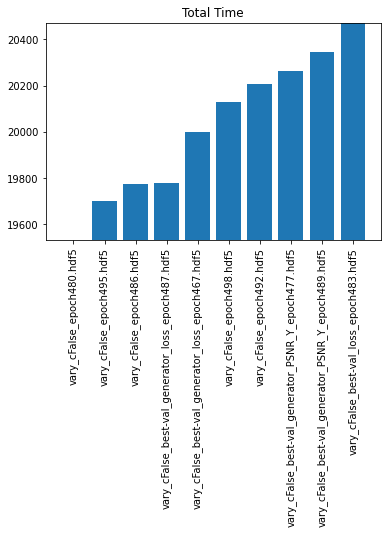

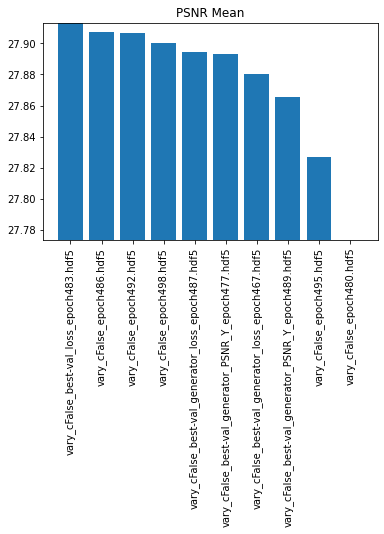

In [64]:
evaluate_models(3)

Number of matching training jobs: 1


100%|██████████| 10/10 [01:27<00:00,  8.67s/it]

100%|██████████| 10/10 [01:27<00:00,  8.79s/it]


,Name,Params,Epoch,Arch,Vary Compression,Compression,Sharpen,Dataset,Total Time,Time per 100 pixels,PSNR Mean,PSNR Median,SSIM Mean,SSIM Median
1,vary_cFalse_epoch469.hdf5,C1-D2-G4-G064-T10-x4,469,rdn,False,100,0,div2k,648.740,2.002284,25.516205,24.754544,0.686094,0.694703
3,vary_cFalse_best-val_generator_PSNR_Y_epoch495...,C1-D2-G4-G064-T10-x4,495,rdn,False,100,0,div2k,611.856,1.888444,25.506224,24.767196,0.686179,0.695001
2,vary_cFalse_best-val_generator_loss_epoch493.hdf5,C1-D2-G4-G064-T10-x4,493,rdn,False,100,0,div2k,632.339,1.951664,25.504067,24.760942,0.685949,0.694445
9,vary_cFalse_epoch498.hdf5,C1-D2-G4-G064-T10-x4,498,rdn,False,100,0,div2k,603.566,1.862858,25.498180,24.757402,0.684967,0.694075
4,vary_cFalse_best-val_loss_epoch490.hdf5,C1-D2-G4-G064-T10-x4,490,rdn,False,100,0,div2k,606.440,1.871728,25.493444,24.764360,0.685464,0.694038
5,vary_cFalse_epoch480.hdf5,C1-D2-G4-G064-T10-x4,480,rdn,False,100,0,div2k,606.834,1.872944,25.492980,24.757678,0.685110,0.693898
7,vary_cFalse_best-val_generator_loss_epoch494.hdf5,C1-D2-G4-G064-T10-x4,494,rdn,False,100,0,div2k,602.522,1.859636,25.486983,24.760551,0.686095,0.694283
6,vary_cFalse_best-val_generator_loss_epoch491.hdf5,C1-D2-G4-G064-T10-x4,491,rdn,False,100,0,div2k,606.950,1.873302,25.485973,24.761648,0.685512,0.694176
8,vary_cFalse_epoch486.hdf5,C1-D2-G4-G064-T10-x4,486,rdn,False,100,0,div2k,602.885,1.860756,25.471236,24.759709,0.685805,0.694521
0,vary_cFalse_epoch483.hdf5,C1-D2-G4-G064-T10-x4,483,rdn,False,100,0,div2k,634.318,1.957772,25.468573,24.756156,0.685091,0.693793


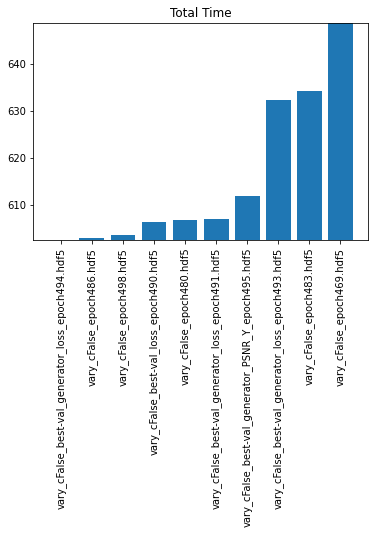

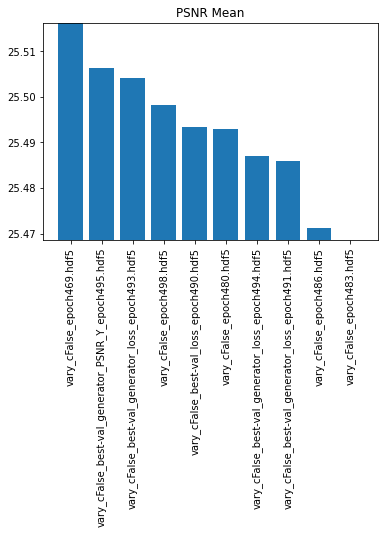

Number of matching training jobs: 1


100%|██████████| 10/10 [01:32<00:00,  9.27s/it]

100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


,Name,Params,Epoch,Arch,Vary Compression,Compression,Sharpen,Dataset,Total Time,Time per 100 pixels,PSNR Mean,PSNR Median,SSIM Mean,SSIM Median
8,vary_cFalse_epoch498.hdf5,C1-D10-G64-G064-T10-x4,498,rdn,False,100,0,div2k,1500.670,4.631698,25.711262,24.946300,0.693515,0.700004
4,vary_cFalse_best-val_loss_epoch492.hdf5,C1-D10-G64-G064-T10-x4,492,rdn,False,100,0,div2k,1024.975,3.163503,25.706330,24.950357,0.694828,0.701606
9,vary_cFalse_best-val_generator_loss_epoch489.hdf5,C1-D10-G64-G064-T10-x4,489,rdn,False,100,0,div2k,1024.967,3.163478,25.698924,24.943868,0.693699,0.700420
1,vary_cFalse_best-val_loss_epoch487.hdf5,C1-D10-G64-G064-T10-x4,487,rdn,False,100,0,div2k,1060.676,3.273691,25.691623,24.947113,0.693875,0.701314
3,vary_cFalse_best-val_generator_loss_epoch491.hdf5,C1-D10-G64-G064-T10-x4,491,rdn,False,100,0,div2k,1036.218,3.198204,25.690415,24.937223,0.693927,0.699510
7,vary_cFalse_best-val_loss_epoch490.hdf5,C1-D10-G64-G064-T10-x4,490,rdn,False,100,0,div2k,1014.803,3.132108,25.690108,24.939639,0.694270,0.700225
6,vary_cFalse_epoch480.hdf5,C1-D10-G64-G064-T10-x4,480,rdn,False,100,0,div2k,1007.216,3.108691,25.659974,24.924520,0.692711,0.699872
5,vary_cFalse_epoch495.hdf5,C1-D10-G64-G064-T10-x4,495,rdn,False,100,0,div2k,1036.167,3.198046,25.657306,24.914652,0.692837,0.698772
0,vary_cFalse_epoch486.hdf5,C1-D10-G64-G064-T10-x4,486,rdn,False,100,0,div2k,1028.806,3.175327,25.648261,24.910889,0.692005,0.698517
2,vary_cFalse_epoch466.hdf5,C1-D10-G64-G064-T10-x4,466,rdn,False,100,0,div2k,1027.932,3.172630,25.634764,24.902799,0.693037,0.700197


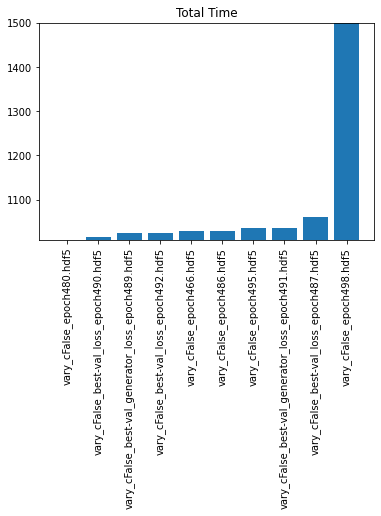

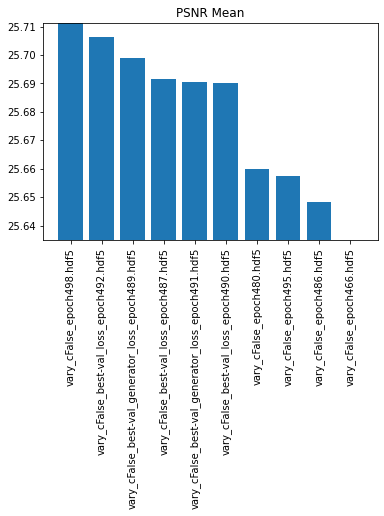

Number of matching training jobs: 1


100%|██████████| 10/10 [02:45<00:00, 16.44s/it]

100%|██████████| 10/10 [02:45<00:00, 16.50s/it]


,Name,Params,Epoch,Arch,Vary Compression,Compression,Sharpen,Dataset,Total Time,Time per 100 pixels,PSNR Mean,PSNR Median,SSIM Mean,SSIM Median
8,vary_cFalse_epoch497.hdf5,C4-D3-G32-G064-T10-x4,497,rrdn,False,100,0,div2k,8245.089,25.447806,26.382354,25.495825,0.724895,0.740948
5,vary_cFalse_best-val_generator_PSNR_Y_epoch488...,C4-D3-G32-G064-T10-x4,488,rrdn,False,100,0,div2k,7590.938,23.428821,26.379515,25.503544,0.724850,0.742247
0,vary_cFalse_epoch491.hdf5,C4-D3-G32-G064-T10-x4,491,rrdn,False,100,0,div2k,7590.300,23.426852,26.367882,25.484426,0.724380,0.742015
2,vary_cFalse_best-val_loss_epoch478.hdf5,C4-D3-G32-G064-T10-x4,478,rrdn,False,100,0,div2k,8159.203,25.182725,26.363139,25.492032,0.724770,0.743520
9,vary_cFalse_best-val_generator_PSNR_Y_epoch499...,C4-D3-G32-G064-T10-x4,499,rrdn,False,100,0,div2k,7505.119,23.163948,26.362628,25.478472,0.724446,0.743010
7,vary_cFalse_best-val_generator_PSNR_Y_epoch476...,C4-D3-G32-G064-T10-x4,476,rrdn,False,100,0,div2k,7504.222,23.161179,26.351652,25.464175,0.724236,0.742443
4,vary_cFalse_best-val_generator_loss_epoch480.hdf5,C4-D3-G32-G064-T10-x4,480,rrdn,False,100,0,div2k,7582.562,23.402969,26.350836,25.478757,0.724409,0.741440
1,vary_cFalse_epoch483.hdf5,C4-D3-G32-G064-T10-x4,483,rrdn,False,100,0,div2k,7570.790,23.366636,26.350309,25.487295,0.723805,0.740793
3,vary_cFalse_epoch494.hdf5,C4-D3-G32-G064-T10-x4,494,rrdn,False,100,0,div2k,7553.218,23.312401,26.347870,25.467192,0.724397,0.741576
6,vary_cFalse_epoch486.hdf5,C4-D3-G32-G064-T10-x4,486,rrdn,False,100,0,div2k,7597.247,23.448293,26.332126,25.466437,0.724477,0.741774


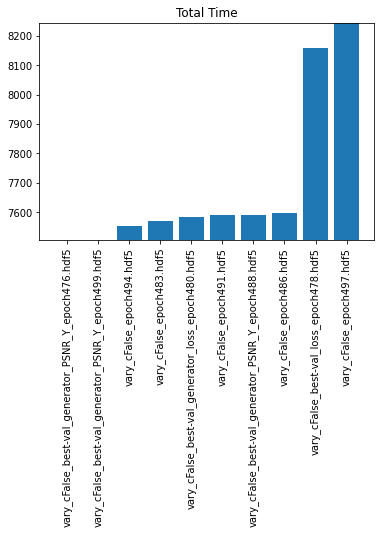

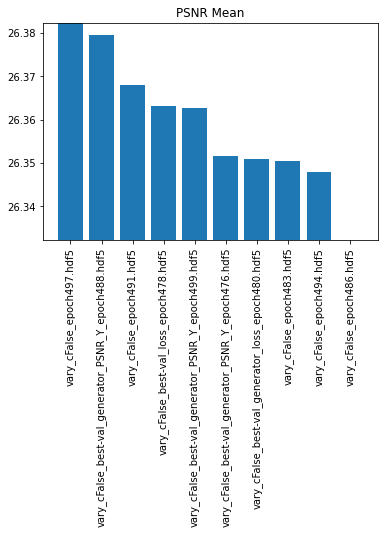

In [8]:
evaluate_models(4)

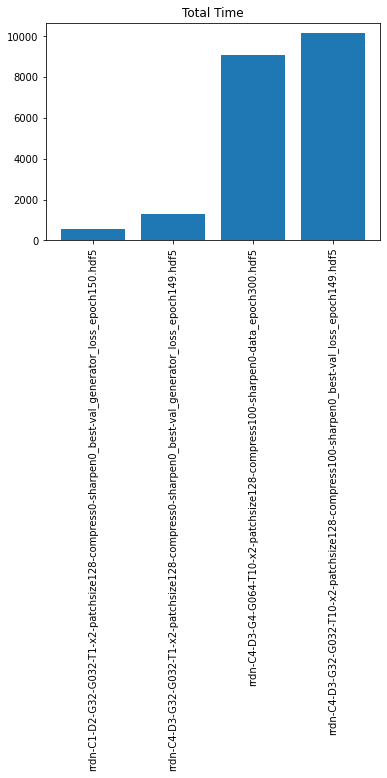

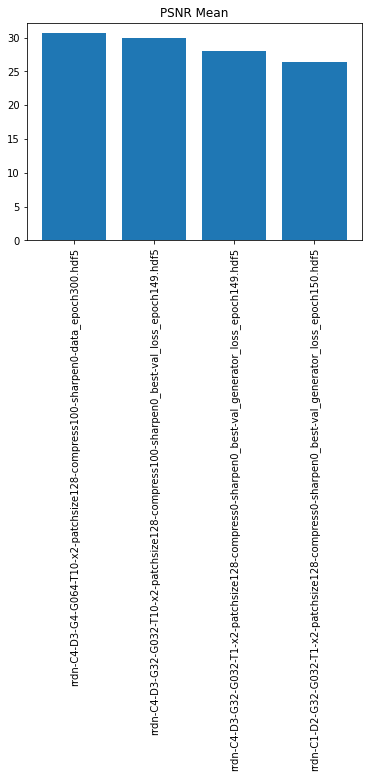

In [6]:
for chart, ascending in [
    ('Total Time', True),
    ('PSNR Mean', False),
    # ('PSNR Median', False),
    # ('SSIM Mean', False),
    # ('SSIM Median', False),
]:
    data = df.sort_values(chart, ascending=ascending).reset_index()
    plt.bar("Name", chart, data = data)
    # plt.bar('Name', 'PSNR Mean', data = data, color='r', alpha=0.5, label='Min Power in mW')
    plt.xticks(rotation = 90)
    plt.title(chart)
    # plt.ylim(data[chart].min() * .98, data[chart].max() * 1.02)
    plt.show()

In [ ]:
validparams={'C': 1, 'D': 2, 'G': 4, 'G0': 64}
reset_cache=True
results = {}
for dataset in [
    '/notebooks/data/div2k/DIV2K_valid_HR', 
    '/notebooks/data/wikiart/preprocessed/4x/valid/hr', 
    '/notebooks/data/ffhq/preprocessed/4x/valid/hr'
]:

    results[dataset] = evaluate_results_against_dataset(
        dataset, 
        validparams=validparams, 
        reset_cache=reset_cache,
        show_worst_n=5,
    )

In [ ]:
display(div2k[0])
display(ffhqd[0])
display(wikiart[0])

# Raw Charts

In [ ]:
for chart, ascending in [
    ('Total Time', True),
    ('PSNR Mean', False),
    # ('PSNR Median', False),
    # ('SSIM Mean', False),
    # ('SSIM Median', False),
]:
    data = df.sort_values(chart, ascending=ascending).reset_index()
    plt.bar("Name", chart, data = data)
    # plt.bar('Name', 'PSNR Mean', data = data, color='r', alpha=0.5, label='Min Power in mW')
    plt.xticks(rotation = 90)
    plt.title(chart)
    # plt.ylim(data[chart].min() * .98, data[chart].max() * 1.02)
    plt.show()

# Charts Superimposed

In [ ]:
def show_chart(df, chart, ascending):
    df = df[['Name', 'Total Time', 'PSNR Mean']].copy()
    for col in ['Total Time', 'PSNR Mean']:
        df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())
    # print(df)
    data = df.sort_values(chart, ascending=ascending).reset_index()
    width = 0.8    
    plt.bar("Name", chart, data = data,  width = width, color='r' if chart is 'Total Time' else 'b', alpha=0.5)

    other_chart = 'PSNR Mean' if chart == 'Total Time' else 'Total Time'
    plt.bar('Name', other_chart, data = data, width=width * .5, color='b' if chart is 'Total Time' else 'r', alpha=0.5)
    plt.xticks(rotation = 90)
    plt.title(chart)
    plt.ylim(data[chart].min() * .98, data[chart].max() * 1.02)
    plt.show()    
    
print('Runs by total time in blue with PSNR superimposed in red')
show_chart(df, 'Total Time', False)

print('Runs by PSNR in red with total time superimposed in blue')
show_chart(df, 'PSNR Mean', False)
# for chart, ascending in [
#     ('Total Time', True),
#     ('PSNR Mean', False),
#     # ('PSNR Median', False),
#     # ('SSIM Mean', False),
#     # ('SSIM Median', False),
# ]:

In [ ]:
dataset = Dataset(pathlib.Path('/notebooks/data/div2k/DIV2K_valid_HR'))
evaluator = Evaluator(dataset)

r = evaluate_jobs(evaluator, '../volumes/checkpoints/weights', validparams={'G0': 4, 'C': 1}, show_worst_n=5)

In [ ]:
dataset = Dataset(pathlib.Path('/notebooks/data/div2k/DIV2K_valid_HR'))
evaluator = Evaluator(dataset)

r = evaluate_jobs(evaluator, '../volumes/checkpoints/weights', validparams={'G0': 64, 'G': 64, 'C': 1, 'D': 10}, show_worst_n=5)

<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />

In [ ]:
dataset = Dataset(pathlib.Path('/notebooks/data/div2k/DIV2K_valid_HR'))
evaluator = Evaluator(dataset)

evaluate_jobs(evaluator, '../volumes/checkpoints/weights', validparams={'G': 64, 'C': 4, 'D': 10})

In [ ]:
evaluate_jobs('s3://upscalerjs/esrgan/checkpoints/', validparams={'G': 4})

In [ ]:
from IPython.display import display, HTML
trained_jobs = [t for t in ts]
for trained_job in trained_jobs:
    r = evaluator.evaluate(trained_job.get_model(), output_dir='./outputs', scale=2)
    # r = evaluator.evaluate(RDN(weights='psnr-small'), output_dir='./outputs', scale=2)    
    print(trained_job.get_params())    
    print(r)
    display(HTML('<hr />'))
    # print('Best')
    # r.show_best_n(n=3, row_size=5)
    # print('Worst')
    # r.show_worst_n(n=3, row_size=5)

In [ ]:
from IPython.display import display
from ISR.models import RRDN, RDN
trained_jobs = [t for t in ts]
for trained_job in trained_jobs:
    print(trained_job.get_params())
    r = evaluator.evaluate(trained_job.get_model(), output_dir='./outputs', scale=2)
    # r = evaluator.evaluate(RDN(weights='psnr-small'), output_dir='./outputs', scale=2)    
    
    print(r)
    print('Best')
    r.show_best_n(n=3, row_size=5)
    print('Worst')
    r.show_worst_n(n=3, row_size=5)

In [ ]:
from IPython.display import display
from ISR.models import RRDN, RDN
trained_jobs = [t for t in ts]
# models.append(RDN(weights='psnr-small'))
for trained_job in trained_jobs[0:]:
    print(trained_job.get_config())
    r = evaluator.evaluate(trained_job.get_model(), output_dir='./outputs')
    print(r)
    print('Best')
    r.show_best_n(n=3, row_size=5)
    print('Worst')
    r.show_worst_n(n=3, row_size=5)

In [ ]:
from IPython.display import display
from ISR.models import RRDN, RDN
models = [
    # ('psnr-small', RDN(weights='psnr-small'), 2),
    # ('psnr-large', RDN(weights='psnr-large'), 2),
    ('gans', RRDN(weights='gans'), 4),
]
for name, model, scale in models:
    print(name)
    r = evaluator.evaluate(model, output_dir='./outputs', scale=scale)
    print(r)
    print('Best')
    r.show_best_n(n=3, row_size=5)
    print('Worst')
    r.show_worst_n(n=3, row_size=5)